In [111]:
import seaborn
import matplotlib.style
import matplotlib as mpl

mpl.style.use('default')
mpl.style.use('seaborn-colorblind')

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

from lightkurve import search_lightcurvefile
from altaipony.flarelc import FlareLightCurve
from altaipony.fakeflares import aflare
from altaipony.ffd import FFD

import os
import copy

import numpy as np
import pandas as pd

#from funcs.custom_detrending import custom_detrending, iteratively_remove_sines
from funcs.helper import read_custom_aperture_lc
from funcs.multiperiod import find_period, fetch_lightcurve, remove_sinusoidal

from altaipony.lcio import from_path, from_mast

from find_and_characterize_flares import custom_detrend

#import astropy.units as u

from scipy import optimize
from scipy.misc import derivative

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

import pytest

In [4]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")
target = lcs.loc[0]


,ID,QCS,typ,cadence_min,mission,prefix,origin,h_mission,SpT,view_start,...,tlumerr,kflux,kfluxerr,klum,klumerr,gmag,jmag,kmag,i_mu,i_sigma
0,100004076,14,slc,1,kep,KIC,generic,Kepler,L1,1356.50,...,6.553810e+27,6.712990e-13,4.272880e-14,2.263849e+28,1.444680e+27,17.8356,13.078,11.771,0.859459,0.080231
1,237880881,1,slc,2,tess,TIC,generic,TESS,M5,1331.00,...,5.645140e+29,1.272670e-11,6.844750e-13,3.232358e+30,1.750110e+29,14.9796,11.530,10.636,0.371856,0.040246
2,44984200,10,slc,2,tess,TIC,custom,TESS,M6,1587.25,...,6.480260e+28,2.018160e-11,1.412120e-12,2.979395e+29,2.089910e+28,14.4115,10.309,9.268,0.578452,0.028256
3,277539431,12,slc,2,tess,TIC,custom,TESS,M7,1641.00,...,1.051740e+29,1.380730e-11,1.517240e-12,3.103479e+29,3.444490e+28,14.7381,10.630,9.666,1.520214,0.041615
4,230120143,16,slc,2,tess,TIC,generic,TESS,M7,1741.00,...,3.430260e+29,4.102720e-11,4.508350e-12,1.023014e+30,1.126940e+29,13.5557,9.854,8.950,0.419312,0.017265


In [126]:
flcs = from_mast(f"{target.prefix} {target.ID}", cadence="short", c=14, mission="Kepler")

Found cached file /home/ekaterina/.lightkurve-cache/mastDownload/Kepler/kplr100004076_sc_Q000000000000003000/kplr100004076-2012211050319_slc.fits with expected size 4561920.
19% (8480/45330) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
19% (8480/45330) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
Found cached file /home/ekaterina/.lightkurve-cache/mastDownload/Kepler/kplr100004076_sc_Q000000000000003000/kplr100004076-2012242122129_slc.fits with expected size 4458240.
0% (106/44280) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
0% (106/44280) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
Found cached file /home/ekaterina/.lightkurve-cache/mastDownload/Kepler/kplr100004076_sc_Q000000000000003000/kplr100004076-2012277125453_slc.fits with expected size 5045760.
0% (161/50160) of the cadences will be ignored due to the quality mask (quality_bi

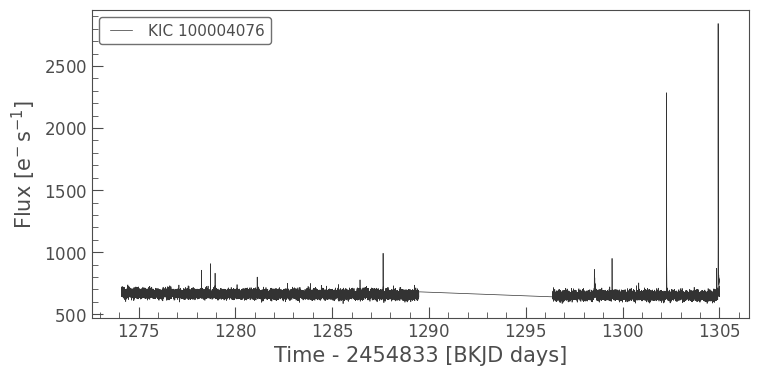

In [127]:
flc=flcs[0]
flc.plot()

In [128]:
# flc = from_mast(f"{target.prefix} {target.ID}", cadence="short", c=sec, mission="TESS")

# flc.plot()
flcc = custom_detrend(flc, target=target)
subsec = 0
flares = flcc.find_flares().flares
flares["ID"] = target.ID
flares["sector"] = target.QCS
flares["subsector"] = subsec
flares["dur"] = flares.tstop - flares.tstart


print("Before loading extra events: ", flc.fake_flares.shape[0])

outpath = f"{CWD}/analysis/results/flarefind/{target.ID}_s{target.QCS}_{subsec}_fake_flares.csv"
flc.load_injrec_data(outpath)
flc.fake_flares = flc.fake_flares.drop_duplicates(keep=False).astype(float)

print("After loading extra events: ", flc.fake_flares.shape[0])

KIC 100004076 modulation period:  8.89812861709689 h
Relative amplitude of modulation: -1.0e-02


Found 2 candidate(s) in the (0,22219) gap.
Found 6 candidate(s) in the (22219,34810) gap.


Before loading extra events:  0
After loading extra events:  2252


17
[0.06162537 0.37128728 0.68094919 0.9906111  1.30027301 1.60993492
 1.91959683 2.22925874 2.53892066 2.84858257 3.15824448 3.46790639
 3.7775683  4.08723021 4.39689212 4.70655403 5.01621594] [0.00034238 0.00670659 0.01307079 0.01943499 0.02579919 0.03216339
 0.03852759 0.04489179 0.05125599 0.05762019 0.06398439 0.07034859
 0.07671279 0.08307699 0.08944119 0.0958054  0.1021696 ]
[0.06162537 0.37128728 0.68094919 0.9906111  1.30027301 1.60993492
 1.91959683 2.22925874 2.53892066 2.84858257 3.15824448 3.46790639
 3.7775683  4.08723021 4.39689212 4.70655403 5.01621594] [0.00034238 0.00670659 0.01307079 0.01943499 0.02579919 0.03216339
 0.03852759 0.04489179 0.05125599 0.05762019 0.06398439 0.07034859
 0.07671279 0.08307699 0.08944119 0.0958054  0.1021696 ]
[0.06162537 0.37128728 0.68094919 0.9906111  1.30027301 1.60993492
 1.91959683 2.22925874 2.53892066 2.84858257 3.15824448 3.46790639
 3.7775683  4.08723021 4.39689212 4.70655403 5.01621594] [0.00034238 0.00670659 0.01307079 0.019434

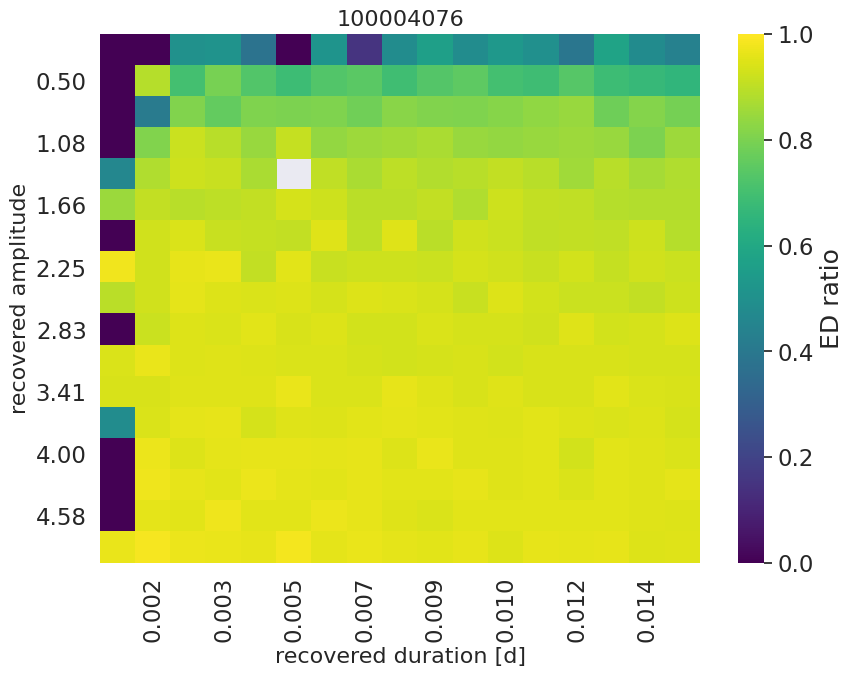

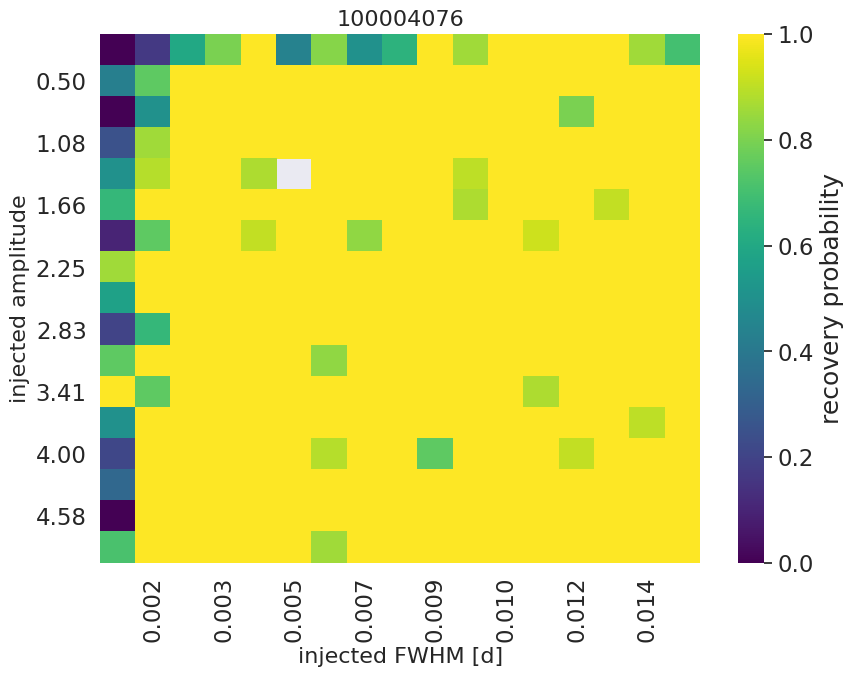

In [129]:
flc.flares = flares
density = 8
flc = flc.characterize_flares(flares_per_bin=density)

flc.plot_ed_ratio_heatmap(flares_per_bin=density)

flc.plot_recovery_probability_heatmap(flares_per_bin=density)

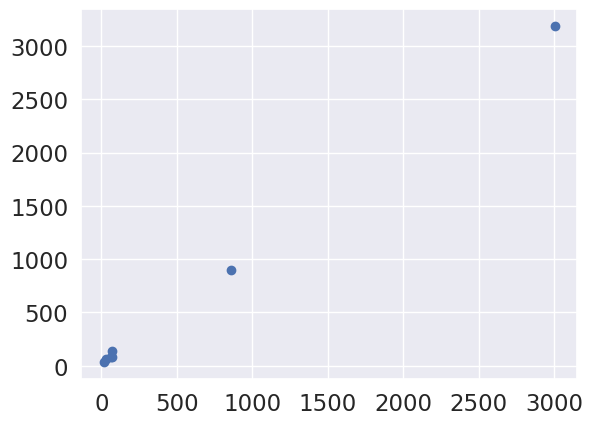

In [130]:
plt.scatter(flc.flares.ed_rec,flc.flares.ed_corr )
# plt.xscale("log")

In [131]:
flc.flares.T

,0,1,2,3,4,5,6,7
istart,17774,19523,25341,25415,26688,30803,34594,34701
istop,17778,19526,25391,25418,26692,30833,34601,34789
cstart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cstop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tstart,1286.44,1287.63,1298.54,1298.59,1299.46,1302.27,1304.86,1304.93
tstop,1286.44,1287.63,1298.57,1298.59,1299.46,1302.29,1304.86,1304.99
ed_rec,33.1426,66.2092,553.223,17.831,69.4846,859.023,68.3844,3003.1
ed_rec_err,3.08069,2.59386,10.6609,2.74417,2.88269,5.98844,3.82922,9.54804
ampl_rec,0.174348,0.513509,0.314446,0.116677,0.461225,2.49203,0.32943,3.34711
total_n_valid_data_points,34810,34810,34810,34810,34810,34810,34810,34810


# View an save characterized flares

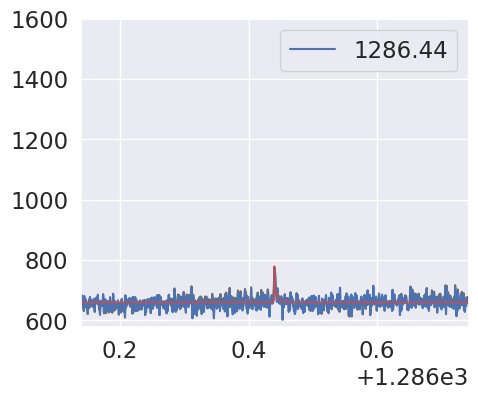

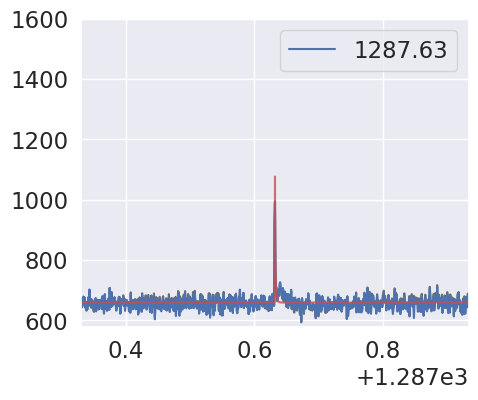

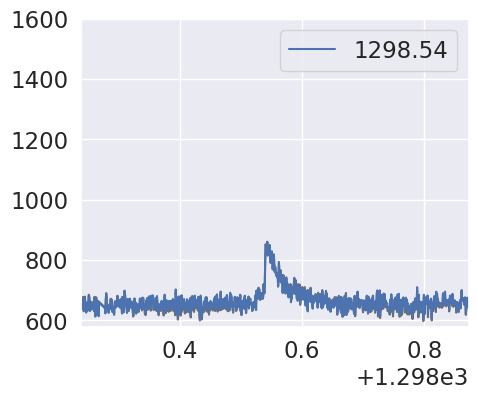

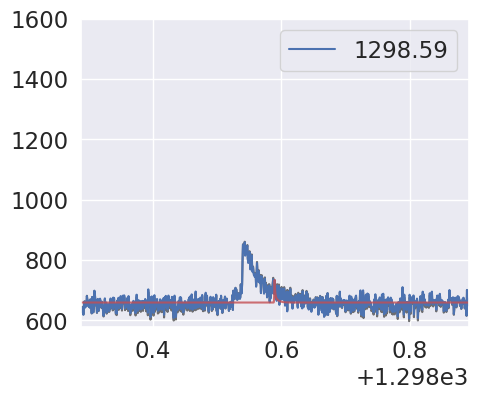

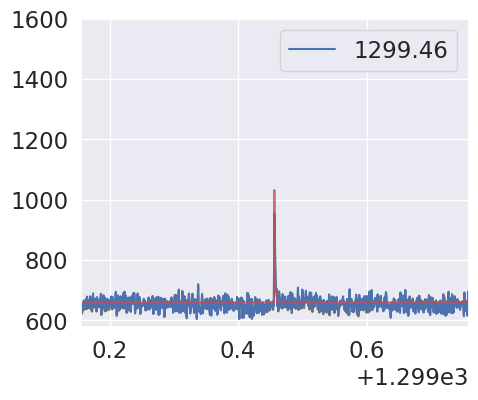

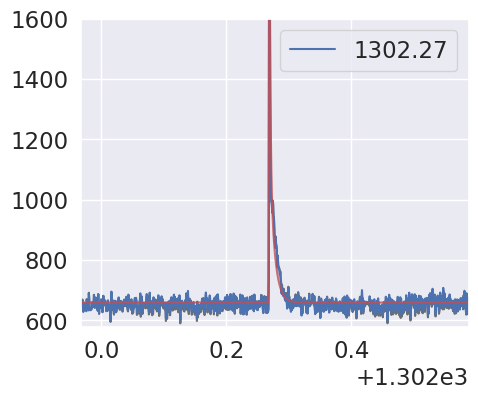

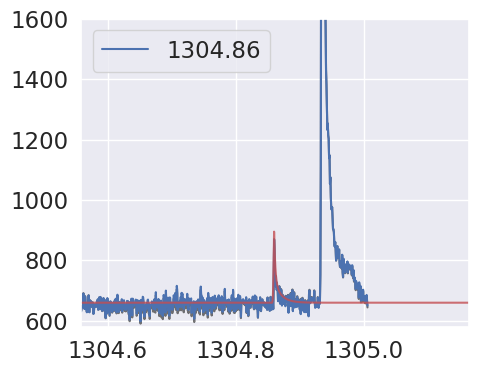

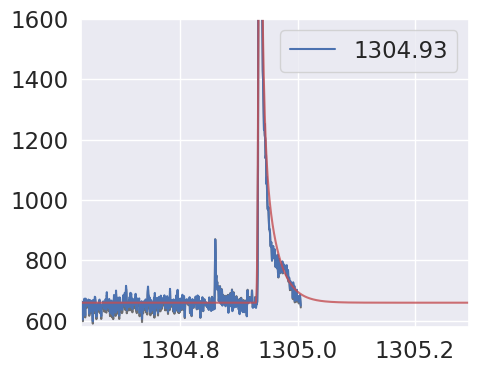

In [195]:
for i, r in flc.flares.iterrows():
    plt.figure(figsize=(5,4))
    plt.plot(flc.time, flc.flux,c="k",alpha=.6)
    plt.plot(flcc.time, flcc.detrended_flux,c="b",label=f"{r.tstart:.2f}")
    sta, sto = r.tstart, r.tstop
    plt.xlim(r.tstart-.3,r.tstop+.3)
    t = np.linspace(r.tstart-.3,r.tstop+.3,3000)
    wh = (flcc.time>=sta) & (flcc.time<=sto)
    plt.plot(t,
             np.mean(flcc.flux)+
             np.mean(flc.flux)*aflare(t, flcc.time[wh][np.argmax(flcc.detrended_flux[wh])], 
                    r.duration_corr, r.amplitude_corr,),c="r",alpha=.8)
    plt.ylim(np.nanmin(1.*flcc.detrended_flux),1600)#1.*np.nanmax(f.detrended_flux))

    plt.legend()

In [17]:
flc.flares["real"] = 1

In [59]:
with open(f"{CWD}/analysis/results/flarefind/2020_08_all_flares.csv", "a") as f:
    flc.flares.to_csv(f, index=False, header=False)

# FFD analysis

In [60]:
df = pd.read_csv(f"{CWD}/analysis/results/flarefind/2020_08_all_flares.csv")
subdf = df[(df.ID == target.ID) &
        (df.real == 1) ]#&
#        (df.sector == target.QCS)]

In [61]:
len(flc.time)/60./24./365.25

0.06618374020838086

In [115]:
def plot_ffds(flc, ax, subdf):

    # Show the uncorrected flare sample
    f = pd.DataFrame({"ed_rec":subdf.ed_rec})
    ffd = FFD(f=f, tot_obs_time=len(flc.time)/60./24./365.25)
    ed, freq, counts = ffd.ed_and_freq()
    ax.scatter(ed, freq, c="grey", marker="d")

    # Show the corrected flare sample
    f = pd.DataFrame({"ed_rec":subdf.ed_corr.dropna()})
    ffd = FFD(f=f, tot_obs_time=len(flc.time)/60./24./365.25)
    ed, freq, counts = ffd.ed_and_freq()
    ax.scatter(ed, freq, c="k")

    # Fit a powerlaw and plot it
    ffd.fit_powerlaw("mmle")
    ffd.plot_powerlaw(ax=ax)

In [117]:
results = {}

Setting ED with new values, size 16.
Setting frequency values with new values, size 16.
Setting frequency adjusted count values with new values, size 16.
Setting ED with new values, size 14.
Setting frequency values with new values, size 14.
Setting frequency adjusted count values with new values, size 14.


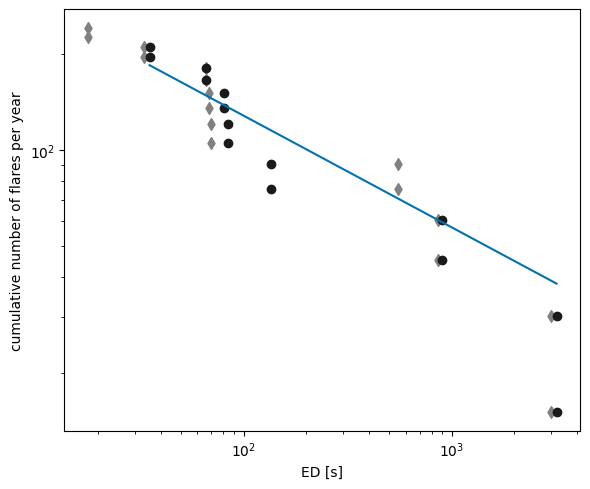

In [118]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 5),)

# Plot FFDs and fit powerlaw
plot_ffds(flc, ax, subdf)

# save results to dict
results[target.ID] = {"alpha":ffd.alpha,
                      "alpha_up_err":ffd.alpha_err,
                      "alpha_low_err":ffd.alpha_err,
                      "beta":ffd.beta,
                      "beta_up_err":ffd.beta_err,
                      "beta_low_err":ffd.beta_err,}

# layout
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("ED [s]")
ax.set_ylabel("cumulative number of flares per year")


plt.tight_layout()

In [119]:
pd.DataFrame(results)

,100004076
alpha,1.350520
alpha_low_err,0.232912
alpha_up_err,0.232912
beta,226.262063
beta_low_err,52.852945
beta_up_err,52.852945


# How often would such a flare occur?

In [202]:
CWD = "/".join(os.getcwd().split("/")[:-2])
df = pd.read_csv(f"{CWD}/analysis/results/mcmc/mcmcoutput.csv")
df = df.drop_duplicates(keep=False).fillna("")
df

,ED_s_16,ED_s_50,ED_s_84,Eflare_erg_16,Eflare_erg_50,Eflare_erg_84,ID,a_16,a_50,a_84,...,phase_deg_50,phase_deg_84,rad_rsun_16,rad_rsun_50,rad_rsun_84,suffix,t0_d_16,t0_d_50,t0_d_84,tstamp
0,23679.233628938244,28430.451939980245,33267.900613053636,2.6671583118473893e+34,3.202321383772594e+34,3.7471971867105346e+34,277539431,2.049082759393461,2.464020916423625,2.8875033523019,...,240.68180823332247,243.32136411401763,16.37016820133466,18.0028165265795,19.54639765783758,,1641.842849528297,1641.8446119376697,1641.8458447765954,08_07_2020_11_48
2,4939.393681690124,4987.53301895416,5031.502652639912,4.381582618671682e+34,4.424285528588007e+34,4.463289624054422e+34,237880881,2.7562492209603655,2.7764773291748086,2.7896262149455042,...,158.78029826328049,158.88846613264974,28.955835833882716,29.07201838036391,29.14738369200908,a,1331.6638532655766,1331.6638712232075,1331.6638882084578,11_02_2020_10_07
4,4689.252093899038,4724.917109765651,4772.268163716125,4.159689790542758e+34,4.191327117649338e+34,4.233330765938046e+34,237880881,0.5093900718853825,0.5135977542757703,0.5189529058518371,...,158.78029826328049,158.88846613264974,12.012733787925868,12.062988930247169,12.126665803059485,b,1331.8263942769738,1331.8265408891405,1331.8266858632876,11_02_2020_10_07


In [201]:
df[df.ID==target.ID]
# Get uncertainties here, too!
# ED_s_50, s_84, s_16
ffd.beta / (ffd.alpha - 1.) * np.power(ED,-ffd.alpha+1)

,ED_s_16,ED_s_50,ED_s_84,Eflare_erg_16,Eflare_erg_50,Eflare_erg_84,ID,a_16,a_50,a_84,...,phase_deg_50,phase_deg_84,rad_rsun_16,rad_rsun_50,rad_rsun_84,suffix,t0_d_16,t0_d_50,t0_d_84,tstamp


# Does the amplitude duration ratio fit in with the rest of the flares from that star?

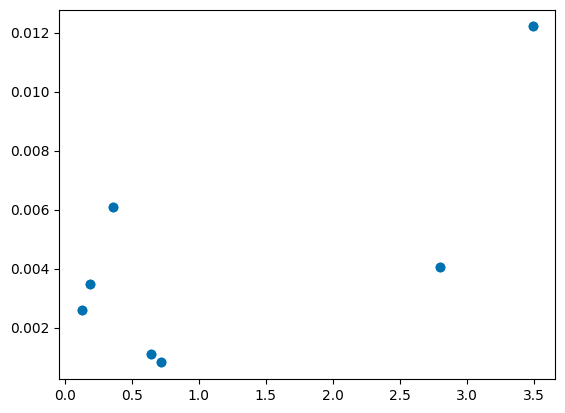

In [121]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 5),)

ax.scatter(subdf.duration_corr,subdf.amplitude_corr, marker="x")
ax.set_ylabel("corrected amplitude")
ax.set_ylabel("corrected FWHM")